$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Experiments On Raw Binaries
<a id=ACISDetectorRaw></a>
Experimenting with model architectures


In [1]:
import os
import re
import sys
import glob
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch

import isadetect.helpers as isa_api 
import src.arch_v2_classifier as arch_api
import src.hyperparams as hp
from src.binary_dataset import FeatureDataset,DatasetToTuple,RawBinaryDataset
import src.arch_trainer as training

%matplotlib inline
%load_ext autoreload
%autoreload 2
RESULT_DIR = "./experiments"
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Preprocessing 
We recommend to download this [dataset](https://github.com/kfirgirstein/ACISDetector/releases/download/Dataset/binary_raw.json.tar.gz) before you run this block. 
After the dataset has been downloaded, place it on: '.pytorch-datasets' folder which should be located in in your home folder

In [2]:
import pathlib
import tarfile
import urllib
import shutil
DOWNLOAD_URL = 'https://github.com/kfirgirstein/ACISDetector/releases/download/Dataset/binary_raw.json.tar.gz'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_dataset(out_path=DATA_DIR, url=DOWNLOAD_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    tar_out_filename = os.path.join(out_path, os.path.basename(url))
    out_filename = tar_out_filename[:tar_out_filename.find(".tar")]

    if os.path.isfile(out_filename) and not force:
        print(f'Dataset file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(tar_out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {tar_out_filename}.')

        tf = tarfile.open(tar_out_filename)
        tf.extractall(out_path)
        print(f"All dataset extracte\nYou can start working!.")
    return out_filename

DATASET_FILE = "./dataset/binary_raw.json"
if not os.path.isfile(DATASET_FILE):
    DATASET_FILE = download_dataset()
binary_dataset = RawBinaryDataset(DATASET_FILE)

In [3]:
from jupyter_utils.plot import plot_fit, plot_exp_results
import experiments.run_ex as experiments
fig = None
fit_res = []
N = len(binary_dataset)
batch_size = 64
num_classes = 23

print(f'features length: {N}')
train_length = int(0.7* N)
test_length = N - train_length
ds_train,ds_test = torch.utils.data.random_split(binary_dataset,(train_length,test_length))
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=batch_size, shuffle=True)
print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')
x0,y0 = ds_train[0]
dataset_shape = (x0.shape if x0.dim() > 0 else 1),(y0.shape if y0.dim() > 0 else 1)
in_size = dataset_shape[0][0]

features length: 115000
Train: 80500 samples
Test: 34500 samples


### CNN conv1 classifier

In [4]:
cnn_hp = hp.cnn_hp()
print(cnn_hp)

{'lr': 0.0001, 'k': 8, 's': 6, 'h_c': [10, 100, 200], 'p': 0, 'd': 1}


### CNN exp

stride = [4,6,8] , kernel = [4,8,16,32], hidden_channels = [[1,1,4],[1,2,4,8,],[10,100,200]]

--- EPOCH 1/30 ---
test_batch (Avg. Loss 2.776, Accuracy 43.2): 100%|██████████| 540/540 [00:09<00:00, 59.89it/s]
--- EPOCH 30/30 ---
test_batch (Avg. Loss 2.484, Accuracy 72.4): 100%|██████████| 540/540 [00:09<00:00, 55.34it/s]
*** Output file ./experiments/exp1_CNN_S4_k8_L10_100_200.json written
--- EPOCH 1/30 ---
test_batch (Avg. Loss 3.080, Accuracy 12.5): 100%|██████████| 540/540 [00:08<00:00, 61.13it/s]
--- EPOCH 30/30 ---
test_batch (Avg. Loss 2.595, Accuracy 61.3): 100%|██████████| 540/540 [00:08<00:00, 60.18it/s]
*** Output file ./experiments/exp1_CNN_S6_k8_L10_100_200.json written
--- EPOCH 1/30 ---
test_batch (Avg. Loss 2.859, Accuracy 34.9): 100%|██████████| 540/540 [00:09<00:00, 56.24it/s]
--- EPOCH 30/30 ---
test_batch (Avg. Loss 2.675, Accuracy 53.1): 100%|██████████| 540/540 [00:09<00:00, 56.45it/s]
*** Output file ./experiments/exp1_CNN_S8_k8_L10_100_200.json written


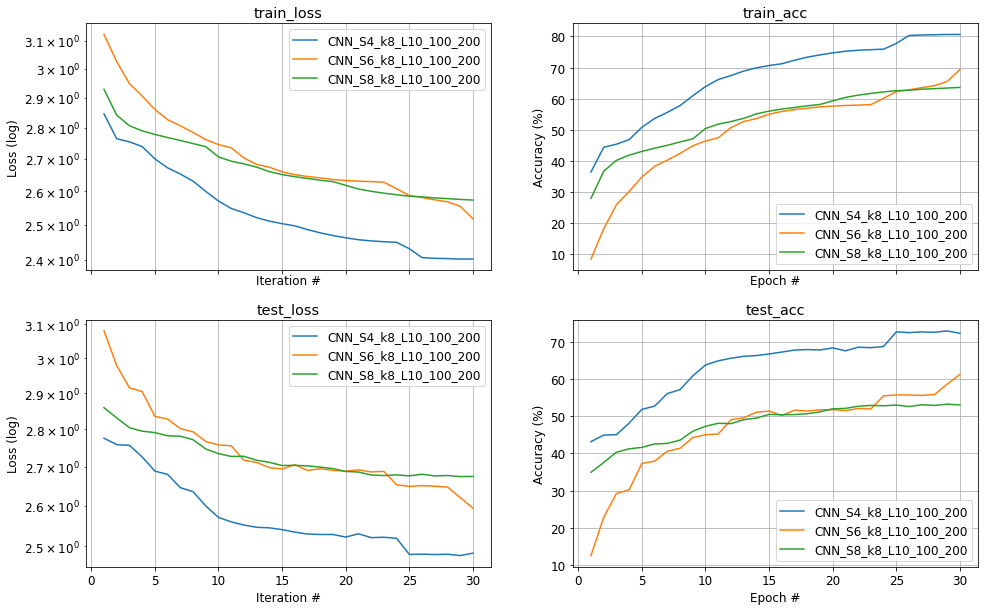

In [13]:
ex_stride = [4,6,8]
for s in ex_stride:
    exp_name = f"exp1_CNN_S{s}_k8_L10_100_200"
    _cnn = arch_api.CNN(in_size,num_classes,kernel_size=cnn_hp["k"], stride=s, dilation = cnn_hp["d"],hidden_channels = cnn_hp["h_c"], padding = cnn_hp["p"])
    optimizer = torch.optim.Adam(_cnn.parameters(), lr=cnn_hp["lr"])
    loss_fn = torch.nn.CrossEntropyLoss()
    trainer = training.ArchTrainer(_cnn, loss_fn, optimizer, device)
    experiments.run_experiment(exp_name,trainer,dl_train,dl_test,num_epochs = 30,print_every=50)
plot_exp_results('exp1_CNN_S*_k8_L10_100_200.json')

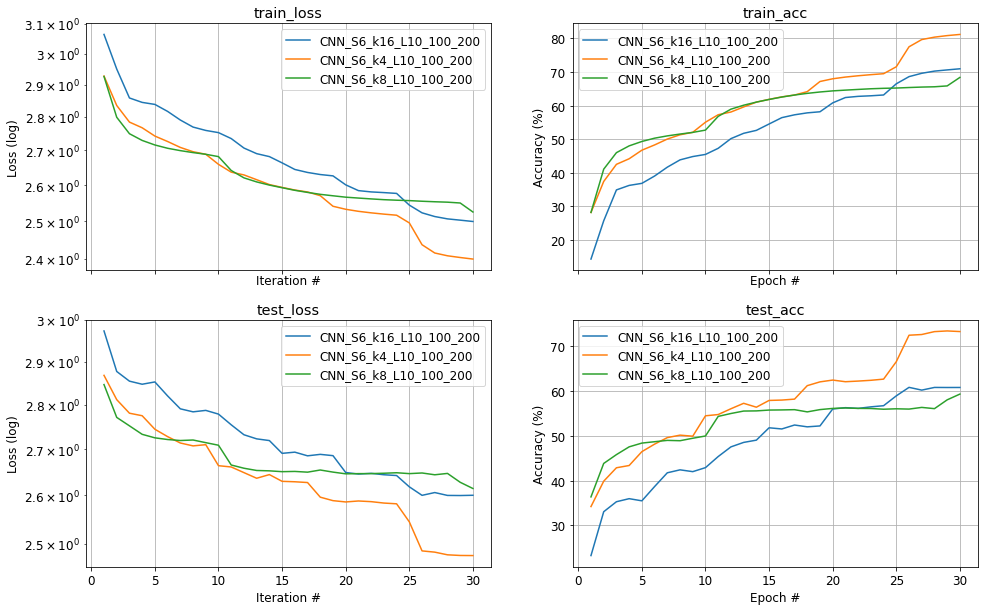

In [20]:
ex_kernel = [4,8,16]
for k in ex_kernel:
    exp_name = f"exp2_CNN_S6_k{k}_L10_100_200"
    if os.path.isfile(f"{os.path.join(RESULT_DIR, exp_name)}.json"):
        continue
    _cnn = arch_api.CNN(in_size,num_classes,kernel_size=k, stride=cnn_hp["s"], dilation = cnn_hp["d"],hidden_channels = cnn_hp["h_c"], padding = cnn_hp["p"])
    optimizer = torch.optim.Adam(_cnn.parameters(), lr=cnn_hp["lr"])
    loss_fn = torch.nn.CrossEntropyLoss()
    trainer = training.ArchTrainer(_cnn, loss_fn, optimizer, device)
    experiments.run_experiment(exp_name,trainer,dl_train,dl_test,num_epochs = 30,print_every=50)
plot_exp_results('exp2_CNN_S6_k*_L10_100_200.json')

--- EPOCH 1/30 ---
test_batch (Avg. Loss 3.147, Accuracy 4.7): 100%|██████████| 540/540 [00:08<00:00, 60.44it/s]
--- EPOCH 30/30 ---
test_batch (Avg. Loss 3.016, Accuracy 18.9): 100%|██████████| 540/540 [00:08<00:00, 67.29it/s]
*** Output file ./experiments/exp3_CNN_S6_k8_L1_2_4.json written
--- EPOCH 1/30 ---
test_batch (Avg. Loss 2.903, Accuracy 30.3): 100%|██████████| 540/540 [00:09<00:00, 57.61it/s]
--- EPOCH 30/30 ---
test_batch (Avg. Loss 2.604, Accuracy 60.4): 100%|██████████| 540/540 [00:08<00:00, 60.89it/s]
*** Output file ./experiments/exp3_CNN_S6_k8_L10_100_200.json written


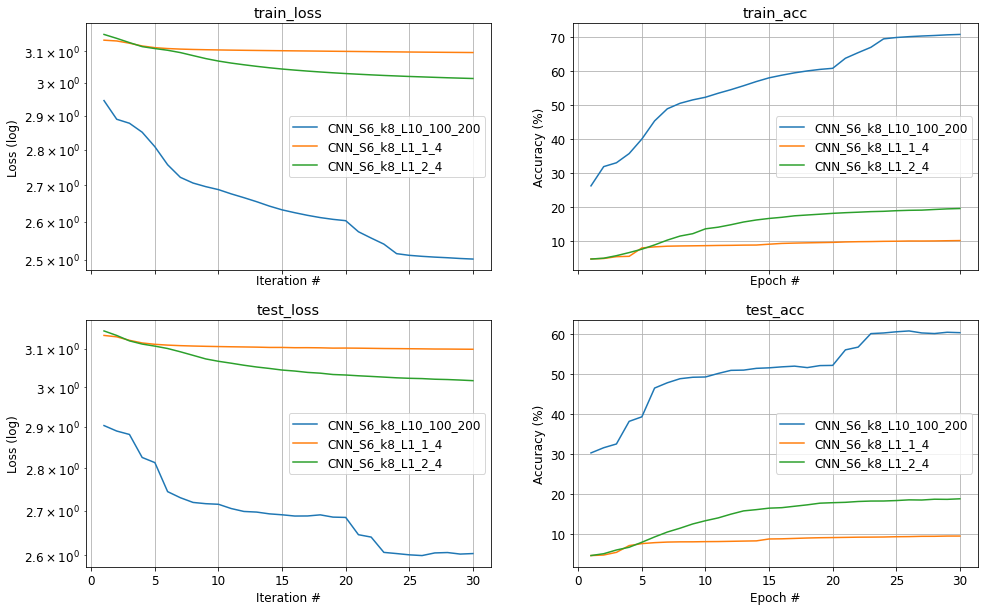

In [24]:
exp_channels = [[1,2,4],[1,1,4],[10,100,200]]
for h_c in exp_channels:
    exp_name = f"exp3_CNN_S6_k8_L{'_'.join(map(str,h_c))}"
    if os.path.isfile(f"{os.path.join(RESULT_DIR, exp_name)}.json"):
        continue
    _cnn = arch_api.CNN(in_size,num_classes,kernel_size=cnn_hp["k"], stride=cnn_hp["s"], dilation = cnn_hp["d"],hidden_channels = h_c, padding = cnn_hp["p"])
    optimizer = torch.optim.Adam(_cnn.parameters(), lr=cnn_hp["lr"])
    loss_fn = torch.nn.CrossEntropyLoss()
    trainer = training.ArchTrainer(_cnn, loss_fn, optimizer, device)
    experiments.run_experiment(exp_name,trainer,dl_train,dl_test,num_epochs = 30,print_every=50)
plot_exp_results('exp3_CNN_S6_k8_L*.json')

### RNN classifier

In [5]:
rnn_hp = hp.rnn_hp()
print(rnn_hp)

{'i_s': 50, 'l': 2, 'h_f': 512, 'lr': 0.0001}


## RNN Exp
input_size = [25,50,100,250,500,1000] , hidden_features = [16,32,64,128,256,512], num_layers = [2,4,8,16]

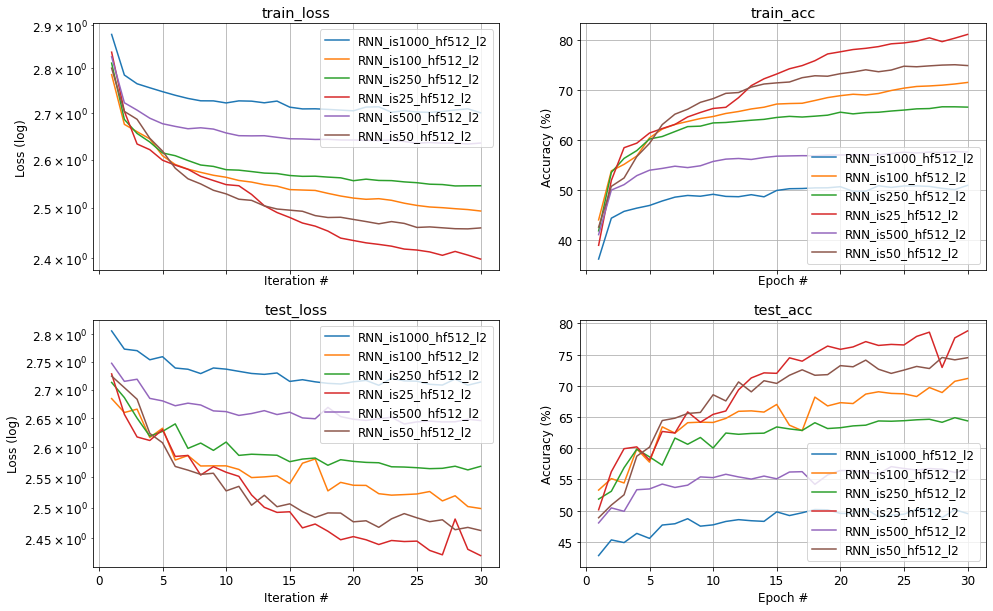

In [6]:
ex_input_size = [25,50,100,250,500,1000]
for i_s in ex_input_size:
    exp_name = f"exp1_RNN_is{i_s}_hf512_l2"
    if os.path.isfile(f"{os.path.join(RESULT_DIR, exp_name)}.json"):
        continue
    _rnn = arch_api.RNN(i_s,batch_size,num_classes,rnn_hp['l'],rnn_hp['h_f'])
    optimizer =torch.optim.Adam(_rnn.parameters(), lr=rnn_hp["lr"])
    loss_fn = torch.nn.CrossEntropyLoss()
    trainer = training.ArchTrainer(_rnn, loss_fn, optimizer, device)
    experiments.run_experiment(exp_name,trainer,dl_train,dl_test,num_epochs = 30,print_every=50)
plot_exp_results('exp1_RNN_is*_hf512_l2.json')

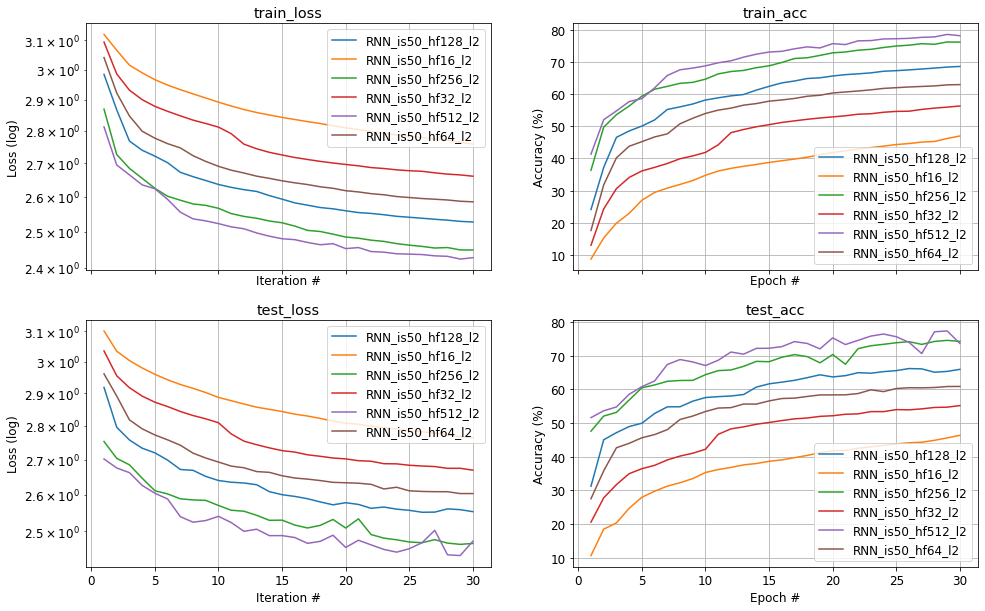

In [7]:
ex_hidden_features = [16,32,64,128,256,512]
for h_f in ex_hidden_features:
    exp_name = f"exp2_RNN_is50_hf{h_f}_l2"
    if os.path.isfile(f"{os.path.join(RESULT_DIR, exp_name)}.json"):
        continue
    _rnn = arch_api.RNN(rnn_hp['i_s'],batch_size,num_classes,rnn_hp['l'],h_f)
    optimizer =torch.optim.Adam(_rnn.parameters(), lr=rnn_hp["lr"])
    loss_fn = torch.nn.CrossEntropyLoss()
    trainer = training.ArchTrainer(_rnn, loss_fn, optimizer, device)
    experiments.run_experiment(exp_name,trainer,dl_train,dl_test,num_epochs = 30,print_every=50)
plot_exp_results('exp2_RNN_is50_hf*_l2.json')

In [ ]:
ex_num_layers = [2,4,8,16]
for l in ex_num_layers:
    exp_name = f"exp3_RNN_is50_hf512_l{l}"
    if os.path.isfile(f"{os.path.join(RESULT_DIR, exp_name)}.json"):
        continue
    _rnn = arch_api.RNN(rnn_hp['i_s'],batch_size,num_classes,l,rnn_hp['h_f'])
    optimizer =torch.optim.Adam(_rnn.parameters(), lr=rnn_hp["lr"])
    loss_fn = torch.nn.CrossEntropyLoss()
    trainer = training.ArchTrainer(_rnn, loss_fn, optimizer, device)
    experiments.run_experiment(exp_name,trainer,dl_train,dl_test,num_epochs = 30,print_every=50)
plot_exp_results('exp3_RNN_is50_hf512_l*.json')

--- EPOCH 1/30 ---
train_batch (2.796):  20%|███████████▍                                              | 249/1258 [01:48<07:40,  2.19it/s]